In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable

%run functions/formatting.py ./
%run functions/color_functions.py ./

# world map to serve as a background
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.drop([159,22,23],inplace=True) # Antarctica, Greenland,Seven seas (tiny islands Indian ocean)

Load details for all 189 basins.

In [2]:
basins=geopandas.read_file('data/basins/basins.shp').set_index('name')
basins.head()

,continent,ocean,area,climate,clim area,cluster,clim name,geometry
name,,,,,,,,
WINISK,"North America, Central America and the Caribbean",Arctic Ocean,65635.3,Dfc,99.743367,other,Snow fully humid cool summer,"POLYGON ((-87.24167 52.32500, -87.24223 52.314..."
COPPER,"North America, Central America and the Caribbean",Pacific Ocean,65704.3,Dfc,56.077317,other,Snow fully humid cool summer,"POLYGON ((-140.15833 61.00000, -140.15890 60.9..."
NOTTAWAY,"North America, Central America and the Caribbean",Arctic Ocean,66053.1,Dfc,96.210946,other,Snow fully humid cool summer,"MULTIPOLYGON (((-73.85417 50.00833, -73.85089 ..."
TALAS,Asia,---,66179.8,BSk,65.765573,other,Arid Steppe cold,"POLYGON ((73.61250 42.33333, 73.60612 42.33277..."
MARONI,South America,Atlantic Ocean,66408.4,Afm,92.235931,other,Equatorial rainforest/monsoon,"POLYGON ((-53.08750 3.20833, -53.08508 3.20798..."


Load NSE and cyclostationary NSE tabs for all combinations.

In [3]:
Ncombinations=1694
Nbasins=189
data_TWS='GRACE_JPL_mascons'
NSE_tab=pd.read_csv("outputs/NSE_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ncombinations,data_TWS),index_col=[0])
NSEc_tab=pd.read_csv("outputs/NSE_cyclic_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ncombinations,data_TWS),index_col=[0])

# NSE results

### Fig. 6: maximum NSE among all combinations

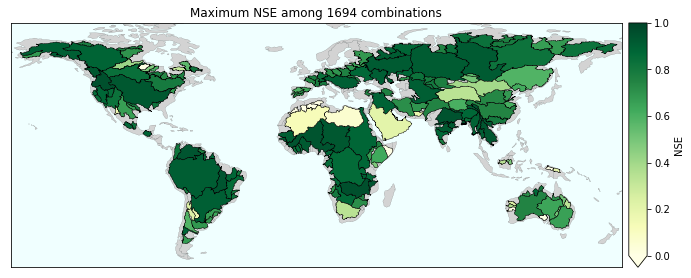

In [4]:
basins_plot=basins.copy()
basins_plot['max NSE']=np.nanmax(NSE_tab.loc[basins.index],axis=1)

fig, ax = plt.subplots(figsize=(9.7,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
basins_plot.plot(ax=ax,column='max NSE',edgecolor='black',linewidth=0.4,
                 cmap=plt.cm.get_cmap('YlGn'),
                 vmin=0,vmax=1,
                 legend=True,cax=cax,
                legend_kwds={'label': "NSE",
                              'extend':'min'
                          },)
ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,80])
ax.set_title('Maximum NSE among {} combinations'.format(Ncombinations))
plt.tight_layout()
plt.show()

### Fig. A1: Distribution of the maximum NSE

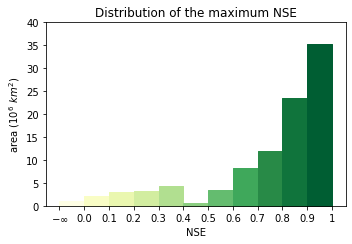

In [5]:
X=pd.DataFrame(np.nanmax(NSE_tab,axis=1),index=NSE_tab.index,columns=['max NSE'])
X['area']=basins['area'].copy()/1e6

cmap = plt.get_cmap('YlGn')(np.linspace(0,1,12))
step=0.1
bins=np.arange(0,1,step)

plt.figure(figsize=(5,3.5))
# all basins below the lower bound
bound=bins[0]
area_basins=X.loc[X['max NSE']<bound,'area'].sum()
plt.fill_between([bound-step,bound],[0,0],[area_basins,area_basins],
                    color=cmap[0])

for i,bound in enumerate(bins):
    area_basins=X.loc[(X['max NSE']>=bound)&(X['max NSE']<bound+step),'area'].sum()
    plt.fill_between([bound,bound+step],[0,0],[area_basins,area_basins],
                    color=cmap[i+1])
plt.ylim([0,40])
plt.xticks([bins[0]-step]+list(bins)+[1],[r'$- \infty$']+list(np.round(bins,1))+[1])
plt.xlabel('NSE')
plt.ylabel('area ($10^6$ $km^2$)')
plt.title('Distribution of the maximum NSE')
plt.tight_layout()
plt.show()

### Fig. 8: Correlation between area and NSE

In [6]:
X=pd.DataFrame(np.nanmax(NSE_tab,axis=1),index=NSE_tab.index,columns=['max NSE'])
for basin_name in X.index:
    X.loc[basin_name,'10th NSE']=NSE_tab.loc[basin_name].sort_values(ascending=False).iloc[9]
X['area']=basins['area'].copy()
X['large climate']=basins['climate'].str[:1]
X

,max NSE,10th NSE,area,large climate
name,,,,
WINISK,0.603721,0.534275,65635.3,D
COPPER,0.916692,0.909671,65704.3,D
NOTTAWAY,0.689401,0.530693,66053.1,D
TALAS,0.823368,0.788340,66179.8,B
MARONI,0.875050,0.845263,66408.4,A
...,...,...,...,...
Tibetan plateau,0.605817,0.572003,590841.4,E
Western Plateau,0.753869,0.691870,1998005.0,B
Puna de Atacama plateau,0.233532,0.145507,101842.2,E


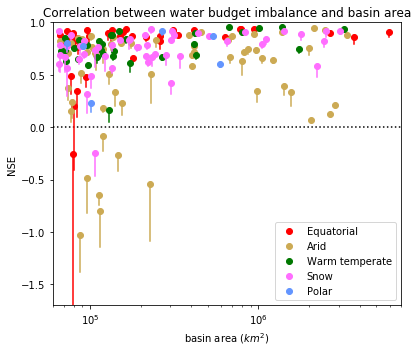

In [7]:
plt.figure(figsize=(6,5))
xmin=6e4
xmax=7e6
plt.plot([xmin,xmax],[0,0],'k:')
for climate,climate_name in zip(['A','B','C','D','E'],['Equatorial','Arid','Warm temperate','Snow','Polar']):
    temp=X.loc[X['large climate']==climate]
    plt.semilogx(temp['area'],temp['max NSE'],'o',color=climate_color_dict[climate],label=climate_name)
    for basin_name in temp.index:
        plt.semilogx([temp.loc[basin_name,'area'],temp.loc[basin_name,'area']],
                     [temp.loc[basin_name,'10th NSE'],temp.loc[basin_name,'max NSE']],
                    color=climate_color_dict[climate])
plt.legend()
plt.xlim([xmin,xmax])
plt.ylim([-1.7,1])
plt.xlabel('basin area ($km^2$)')
plt.ylabel('NSE')
plt.title('Correlation between water budget imbalance and basin area')
plt.tight_layout()
plt.show()

### Fig. 9: NSE depending on climate zone

In [8]:
X=pd.DataFrame(np.nanmax(NSE_tab,axis=1),index=NSE_tab.index,columns=['max NSE'])
X['climate name']=basins['clim name']

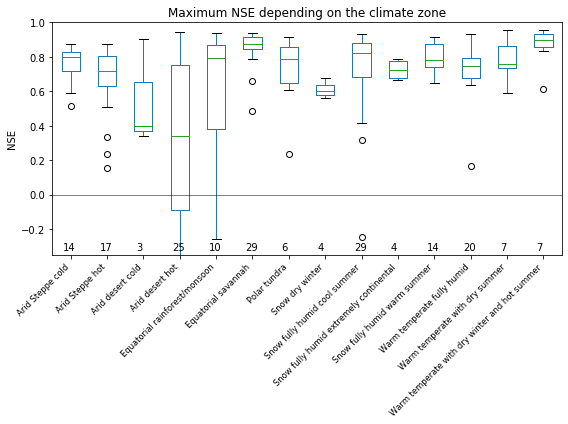

In [9]:
boxplot=X.boxplot(column=['max NSE'],by='climate name',figsize=(8,6),grid=False)
temp=X.groupby('climate name').count()
plt.xticks(np.arange(1,temp.shape[0]+1),temp.index,rotation=45,ha='right',fontsize='small')
i=0.8
for climate,row in temp.iterrows():
    plt.text(i,-0.32,str(row['max NSE']))
    i+=1
plt.plot([0.5,temp.shape[0]+0.5],[0,0],'k',linewidth=0.5)
plt.ylim([-0.35,1])
plt.xlabel('')
plt.ylabel('NSE')
plt.title('Maximum NSE depending on the climate zone')
plt.suptitle('')
plt.tight_layout()

# Cyclostationary NSE results

### Fig. 7: maximum cyclostationary NSE among all combinations

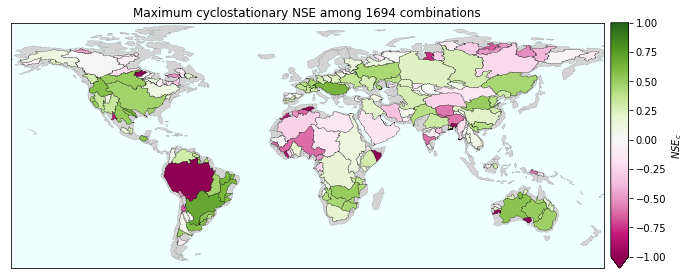

In [10]:
basins_plot=basins.copy()
basins_plot['max NSEc']=np.nanmax(NSEc_tab.loc[basins.index],axis=1)

fig, ax = plt.subplots(figsize=(9.7,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
basins_plot.plot(ax=ax,column='max NSEc',edgecolor='black',linewidth=0.2,
                 cmap=plt.cm.get_cmap('PiYG'),
                 vmin=-1,vmax=1,
                 legend=True,cax=cax,
                legend_kwds={'label': "$NSE_c$",
                              'extend':'min'
                          },)
ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,85])
ax.set_title('Maximum cyclostationary NSE among {} combinations'.format(Ncombinations))
plt.tight_layout()
plt.show()

### Fig A6: Number of combinations with a positive cyclostationary NSE

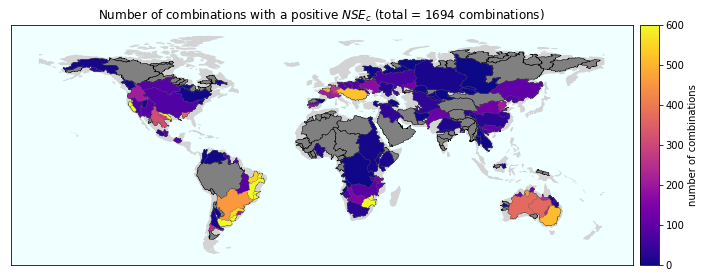

In [11]:
basins_plot=basins.copy()
basins_plot['NSEc>0']=np.sum(NSEc_tab>=0,axis=1)

fig, ax = plt.subplots(figsize=(9.9,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.01)
basins.plot(ax=ax,facecolor='grey',edgecolor='black',linewidth=0.4)
#basins.plot(ax=ax,color='grey',edgecolor='black',linewidth=0.5)
basins_plot.loc[basins_plot['NSEc>0']>0].plot(ax=ax,column='NSEc>0',edgecolor='grey',linewidth=0.1,
                 cmap=plt.cm.get_cmap('plasma'),
                 vmin=0,
                 vmax=600,
                 legend=True,cax=cax,
                legend_kwds={'label': "number of combinations",
                          },)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('azure')
ax.set_title('Number of combinations with a positive $NSE_c$ (total = {} combinations)'.format(NSEc_tab.shape[1]))
plt.tight_layout()
plt.show()

### Fig. 10: NSE and cyclostationary NSE on the same plot

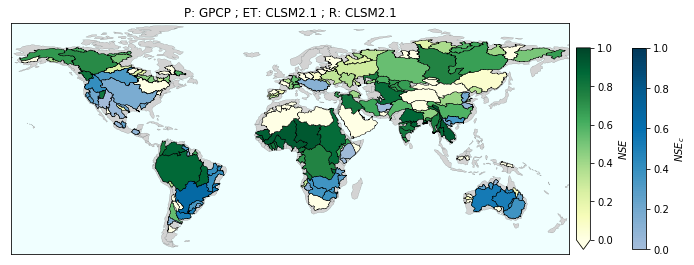

In [12]:
#comb='P_ERA5_Land_ET_ERA5_Land_R_ERA5_Land_TWS_{}'.format(data_TWS)
#comb='P_ERA5_Land_ET_ERA5_Land_R_GRUN_TWS_{}'.format(data_TWS)
#comb='P_MERRA2_ET_MERRA2_R_MERRA2_TWS_{}'.format(data_TWS)
#comb='P_JRA55_ET_JRA55_R_JRA55_TWS_{}'.format(data_TWS)
#comb='P_ERA5_Land_ET_ERA5_Land_R_GLDAS22_CLSM25_TWS_{}'.format(data_TWS)
comb='P_GPCP_ET_GLDAS21_CLSM25_R_GLDAS21_CLSM25_TWS_{}'.format(data_TWS)
#comb='P_GPCP_ET_GLDAS21_NOAH36_R_GLDAS21_NOAH36_TWS_{}'.format(data_TWS)
#comb='P_GPCP_ET_GLDAS21_VIC412_R_GLDAS21_VIC412_TWS_{}'.format(data_TWS)
#comb='P_GLDAS20_ET_GLDAS20_CLSM25_R_GLDAS20_CLSM25_TWS_{}'.format(data_TWS)
#comb='P_GLDAS20_ET_GLDAS20_NOAH36_R_GLDAS20_NOAH36_TWS_{}'.format(data_TWS)
#comb='P_GLDAS20_ET_GLDAS20_VIC412_R_GLDAS20_VIC412_TWS_{}'.format(data_TWS)


basins_plot=basins.copy()
basins_plot['NSE '+comb]=NSE_tab[comb]
basins_plot['NSEc '+comb]=NSEc_tab[comb]

fig, ax = plt.subplots(figsize=(9.7,4))
ax.set_aspect('equal') # trick to hide the first axes behind
ax.set_xticks([])
ax.set_yticks([])
ax1=fig.add_axes([0.01, 0.01, 0.8, 0.95])

world.plot(ax=ax1,color='lightgrey',edgecolor='black',linewidth=0.1)
basins_plot.plot(ax=ax1,column='NSE '+comb,edgecolor='black',linewidth=0.4,
                 cmap=plt.cm.get_cmap('YlGn'),
                 vmin=0,vmax=1)

basins_plot.loc[basins_plot['NSEc '+comb]>0].plot(ax=ax1,column='NSEc '+comb,edgecolor='black',linewidth=0.4,
                 cmap=plt.cm.get_cmap('PuBu'),
                 vmin=-0.6,vmax=1,
                                                 )

cax1 = fig.add_axes([0.82, 0.1, 0.02, 0.7])
clb=fig.colorbar(
    ScalarMappable(cmap=plt.cm.get_cmap('YlGn'), norm=plt.Normalize(0,1)),
    cax=cax1,
    fraction=0.01,
    extend='min',
    label='$NSE$'
    )

cax2 = fig.add_axes([0.9, 0.1, 0.02, 0.7])
clb=fig.colorbar(
    ScalarMappable(cmap=plt.cm.get_cmap('PuBu'), norm=plt.Normalize(-0.6,1)),
    cax=cax2,
    fraction=0.01,
    label='$NSE_c$',
    boundaries=np.arange(0,1.01,0.01),  # Adding values for extensions.
    ticks=np.arange(0,1.1,0.2),
    )


ax1.set_facecolor("azure")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlim([-170,180])
ax1.set_ylim([-60,85])
ax1.set_title('{}'.format(format_combination(comb)))
#plt.tight_layout()
plt.show()

### Table 3: Combinations with the largest area satisfying a positive cyclostationary NSE

In [13]:
Ncomb=25 # number of combinations to plot

# for each basin and combination with NSEc>0, insert the basin area. Otherwise, insert 0.
area_NSEc=pd.DataFrame(np.where(NSEc_tab>0,basins['area'].values.reshape(189,1),0),
                      index=NSEc_tab.index,columns=NSEc_tab.columns)
# same with NSE
area_NSE=pd.DataFrame(np.where(NSE_tab>0,basins['area'].values.reshape(189,1),0),
                      index=NSE_tab.index,columns=NSE_tab.columns)

# for each combination, count the area with NSEc>0
df=area_NSEc.sum(axis=0).to_frame(name='NSEc>0')
df['NSE>0']=area_NSE.sum(axis=0)

# convert area to million km^2
df=(df/1e6).round(1)

# rank combinations by decreasing area
df=df.sort_values(by=['NSEc>0','NSE>0'],ascending=False)

# plot the Ncomb first combinations and some selected combinations
combinations_to_plot=list(df.iloc[:Ncomb].index)
combinations_to_plot.append('P_GLDAS20_ET_GLDAS20_VIC412_R_GLDAS20_VIC412_TWS_{}'.format(data_TWS))
combinations_to_plot.append('P_GLDAS20_ET_GLDAS20_NOAH36_R_GLDAS20_NOAH36_TWS_{}'.format(data_TWS))
combinations_to_plot.append('P_GPCP_ET_GLDAS21_NOAH36_R_GLDAS21_NOAH36_TWS_{}'.format(data_TWS))
combinations_to_plot.append('P_ERA5_Land_ET_GLDAS22_CLSM25_R_GLDAS22_CLSM25_TWS_{}'.format(data_TWS))
combinations_to_plot.append('P_JRA55_ET_JRA55_R_JRA55_TWS_{}'.format(data_TWS))
combinations_to_plot.append('P_GPCP_ET_GLDAS21_VIC412_R_GLDAS21_VIC412_TWS_{}'.format(data_TWS))
df=df.loc[combinations_to_plot]

formatted_combinations=[]
for comb in combinations_to_plot:
    formatted_combinations.append(format_combination(comb))
df.index=formatted_combinations
df

,NSEc>0,NSE>0
P: ERA5 Land ; ET: ERA5 Land ; R: ERA5 Land,35.5,89.7
P: PGF ; ET: CLSM2.0 ; R: CLSM2.0,30.8,90.2
P: ERA5 Land ; ET: ERA5 Land ; R: CLSM2.2,24.5,79.7
P: PGF ; ET: NOAH2.0 ; R: CLSM2.0,23.9,90.9
P: GPCP ; ET: CLSM2.1 ; R: CLSM2.1,23.4,79.2
P: ERA5 Land ; ET: ERA5 Land ; R: GRUN,22.7,81.3
P: MSWEP ; ET: CLSM2.0 ; R: CLSM2.0,21.8,78.5
P: ERA5 Land ; ET: ERA5 Land ; R: CLSM2.0,21.7,78.6
P: ERA5 Land ; ET: ERA5 Land ; R: MERRA2,21.7,76.6
P: GPM ; ET: CLSM2.1 ; R: CLSM2.1,21.1,80.1


# Water budget in individual basins

### Figs. A2 and A4: Water budget in AMAZON and NIGER

In [14]:
basin_name='MACKENZIE'

# combination yielding the highest NSE
#best_comb=NSE_tab.loc[basin_name].sort_values(ascending=False).index[0]
#data_P,data_ET,data_R=decompose_combination(best_comb)[:3]

# Alternatively, you can impose the datasets you want
data_P='ERA5_Land'
data_ET='GLDAS22_CLSM25'
data_R='GLDAS22_CLSM25'
best_comb='P_{}_ET_{}_R_{}_TWS_{}'.format(data_P,data_ET,data_R,data_TWS)

Time-series of P, ET, R, and TWSC (and TWSC uncertainty)

In [15]:
time_idx=pd.date_range('2003-03-01','2014-11-01',freq='MS')

P_monthly=pd.read_csv('data/hydrology_timeseries/P_{}_monthly_filtered.csv'.format(data_P),index_col=[0])
P_monthly.columns=P_monthly.columns.astype('datetime64[ns]')
P_filter=P_monthly.loc[basin_name,time_idx]

ET_monthly=pd.read_csv('data/hydrology_timeseries/ET_{}_monthly_filtered.csv'.format(data_ET),index_col=[0])
ET_monthly.columns=ET_monthly.columns.astype('datetime64[ns]')
ET_filter=ET_monthly.loc[basin_name,time_idx]

R_monthly=pd.read_csv('data/hydrology_timeseries/R_{}_monthly_filtered.csv'.format(data_R),index_col=[0])
R_monthly.columns=R_monthly.columns.astype('datetime64[ns]')
R_filter=R_monthly.loc[basin_name,time_idx]

TWSC_monthly=pd.read_csv('data/hydrology_timeseries/TWS_{}_monthly_filtered.csv'.format(data_TWS),index_col=[0])
TWSC_monthly.columns=TWSC_monthly.columns.astype('datetime64[ns]')
TWSC_filter=TWSC_monthly.loc[basin_name,time_idx]

if data_TWS=='GRACE_JPL_mascons':
    dTWSC_monthly=pd.read_csv('data/hydrology_timeseries/TWS_uncertainty_{}_monthly_filtered.csv'.format(data_TWS),index_col=[0])
    dTWSC_monthly.columns=dTWSC_monthly.columns.astype('datetime64[ns]')
    dTWSC_filter=dTWSC_monthly.loc[basin_name,time_idx]

Mean monthly values to interpret the cyclostationary NSE

In [16]:
df=TWSC_filter.to_frame()
df['month']=TWSC_filter.index.month
df_month=df.groupby('month').mean()
df_month.columns=['mean month']
seasonal_TWSC=df.join(df_month,on='month')

Metrics

In [17]:
A_filter=P_filter-ET_filter-R_filter
RMSD=np.sqrt(np.sum((TWSC_filter-A_filter)**2)/TWSC_filter.shape[0])
NSE=NSE_tab.loc[basin_name,best_comb]
NSEc=NSEc_tab.loc[basin_name,best_comb]
R2=A_filter.corr(TWSC_filter) # Pearson correlation coefficient

if data_TWS=='GRACE_JPL_mascons':
    # percentage of months when the error is below GRACE uncertainty
    GRACE_bounds=100*np.sum(np.abs(A_filter-TWSC_filter)<=dTWSC_filter)/A_filter.shape[0]

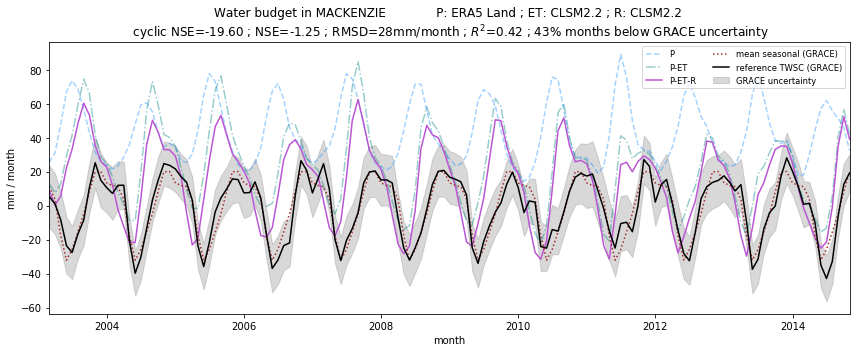

In [18]:
plt.figure(figsize=(12,5))
plt.plot(P_filter,'--',alpha=0.4,color='dodgerblue',label='P')
plt.plot(P_filter-ET_filter,'-.',alpha=0.4,color='teal',label='P-ET')
plt.plot(A_filter,color='mediumorchid',label='P-ET-R')
if data_TWS=='GRACE_JPL_mascons':
    plt.fill_between(TWSC_filter.index,TWSC_filter-dTWSC_filter,TWSC_filter+dTWSC_filter,
                 color='grey',alpha=0.3,label='GRACE uncertainty')
plt.plot(seasonal_TWSC['mean month'],':',color='brown',label='mean seasonal (GRACE)')
plt.plot(TWSC_filter,'k',label='reference TWSC (GRACE)')

plt.xlim([TWSC_filter.index[0],TWSC_filter.index[-1]])
plt.xlabel('month')
plt.ylabel('mm / month')
plt.legend(fontsize='small',ncol=2,loc='upper right')

if data_TWS=='GRACE_JPL_mascons':
    plt.title('Water budget in {}             P: {} ; ET: {} ; R: {} \n cyclic NSE={:.2f} ; NSE={:.2f} ; RMSD={:.0f}mm/month ; $R^2$={:.2f} ; {:.0f}% months below GRACE uncertainty'.format(basin_name,
            dict_dataset_name[data_P],dict_dataset_name[data_ET],dict_dataset_name[data_R],
            NSEc,NSE,RMSD,R2,GRACE_bounds))
else:
    plt.title('Water budget in {}             P: {} ; ET: {} ; R: {} \n cyclic NSE={:.2f} ; NSE={:.2f} ; RMSD={:.0f}mm/month ; $R^2$={:.2f}'.format(basin_name,
            dict_dataset_name[data_P],dict_dataset_name[data_ET],dict_dataset_name[data_R],
            NSEc,NSE,RMSD,R2))
    
plt.tight_layout()
plt.show()

### Figs. A3 and A5: Correlation between budget TWSC and GRACE TWSC

In [19]:
from sklearn.linear_model import LinearRegression

X=TWSC_filter.values.reshape(-1,1)
Y=A_filter.values
model = LinearRegression().fit(X,Y)
r_sq = model.score(X, Y)
print('coefficient of determination:', r_sq)

b=model.intercept_
a=model.coef_[0]

coefficient of determination: 0.17862799523665907


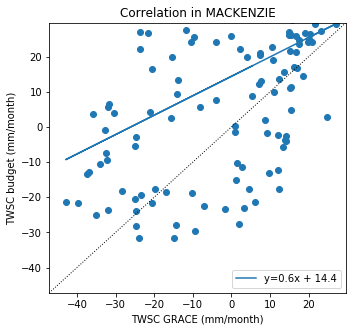

In [20]:
plt.figure(figsize=(5,4.7))
plt.plot([1.1*TWSC_filter.min(),1.05*TWSC_filter.max()],[1.1*TWSC_filter.min(),1.05*TWSC_filter.max()],'k:',linewidth=1)
plt.plot(X,a*X+b,label='y={:.1f}x {} {:.1f}'.format(np.round(a,1),np.where(b>0,'+','-'),np.abs(np.round(b,1))))
plt.scatter(TWSC_filter,A_filter)
plt.xlim([1.1*TWSC_filter.min(),1.05*TWSC_filter.max()])
plt.ylim([1.1*TWSC_filter.min(),1.05*TWSC_filter.max()])
plt.legend()
plt.xlabel('TWSC GRACE (mm/month)')
plt.ylabel('TWSC budget (mm/month)')
plt.title('Correlation in {}'.format(basin_name))
plt.tight_layout()
plt.show()

# Compare datasets

- For precipitation (`'P'`) choose among : `'CPC'`, `'CRU'`, `'GPCC'`, `'GPCP'`, `'GPM'`, `'TRMM'`, `'ERA5_Land'`, `'MERRA2'`, `'JRA55'`, `'GLDAS20'` (PGF), `'MSWEP'`

- For evapotranspiration (`'ET'`) choose among : `'GLDAS20_NOAH36'`, `'GLDAS20_CLSM25'`, `'GLDAS20_VIC412'`, `'GLDAS21_NOAH36'`, `'GLDAS21_CLSM25'`, `'GLDAS21_VIC412'`, `'GLDAS22_CLSM25'`, `'ERA5_Land'`, `'MERRA2'`, `'JRA55'`, `'SSEBop'`, `'GLEAM'`, `'MOD16'`, `'FLUXCOM'`

- For runoff (`'R'`) choose among `'GLDAS20_NOAH36'`, `'GLDAS20_CLSM25'`, `'GLDAS20_VIC412'`, `'GLDAS21_NOAH36'`, `'GLDAS21_CLSM25'`, `'GLDAS21_VIC412'`, `'GLDAS22_CLSM25'`, `'ERA5_Land'`, `'MERRA2'`, `'JRA55'`, `'GRUN'`

- For water storage (`'TWS'`) choose among `'GRACE_JPL_mascons'`, `'GRACE_CSR_mascons'`

Retrieve all datasets used in NSE tables

In [21]:
temp=np.array(list(map(decompose_combination,NSE_tab.columns)))
list_data_P=np.unique(temp[:,0])
list_data_ET=np.unique(temp[:,1])
list_data_R=np.unique(temp[:,2])

In [22]:
def build_combinations(hydro_var_name,data):
    ''' Returns all combinations containing the dataset data for hydro_var_name'''
    comb=[]
    if hydro_var_name=='P':
        for d_ET in list_data_ET:
            for d_R in list_data_R:
                comb.append('P_{}_ET_{}_R_{}_TWS_{}'.format(data,d_ET,d_R,data_TWS))
    elif hydro_var_name=='ET':
        for d_P in list_data_P:
            for d_R in list_data_R:
                comb.append('P_{}_ET_{}_R_{}_TWS_{}'.format(d_P,data,d_R,data_TWS))
    elif hydro_var_name=='R':
        for d_P in list_data_P:
            for d_ET in list_data_ET:
                comb.append('P_{}_ET_{}_R_{}_TWS_{}'.format(d_P,d_ET,data,data_TWS))
    return comb

In [23]:
def mean_10th_best(list_comb,ncomb=10):
    ''' Returns the mean of the 10th highest NSE for each basin '''
    mean10=pd.Series(0,index=NSE_tab.index)
    for basin_name in NSE_tab.index:
        mean10.loc[basin_name]=NSE_tab.loc[basin_name,list_comb].sort_values(ascending=False).iloc[:ncomb].mean()
    return mean10

In [24]:
good_basins=NSE_tab.index[(np.nanmax(NSE_tab,axis=1)>=0.8)|(np.nanmax(NSEc_tab,axis=1)>=0.1)]

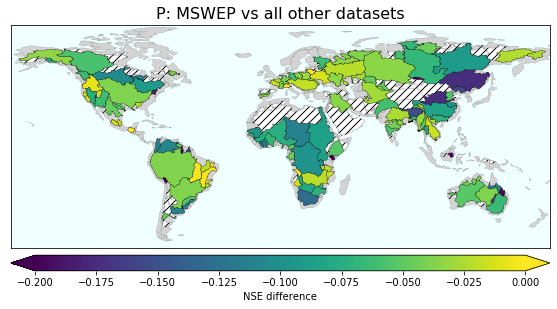

In [25]:
hydro_var_name='P'
data='MSWEP'

ref_comb=build_combinations(hydro_var_name,data)
other_comb=list(set(NSE_tab.columns)-set(ref_comb))

basins_plot=basins.copy()
basins_plot['better {}'.format(data)]=mean_10th_best(ref_comb)-mean_10th_best(other_comb)

fig, ax = plt.subplots(figsize=(9.7,4.4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="7%", pad=0.1)
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
# plot all basins with hatches. for good basins, this will be covered by colors
basins_plot.plot(ax=ax,facecolor='white',hatch='///',edgecolor='black',linewidth=0.1)
basins_plot.loc[good_basins].plot(ax=ax,column='better {}'.format(data),edgecolor='black',linewidth=0.2,
                                  cmap=plt.cm.get_cmap('viridis'),
                                  vmin=-0.2,vmax=0,
                                  legend=True,cax=cax,
                                  legend_kwds={'label': "NSE difference",
                                               'extend':'both',
                                               'orientation':'horizontal'
                                               },
                                  )
ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,85])
ax.set_title('{}: {} vs all other datasets'.format(hydro_var_name,dict_dataset_name[data]),fontsize=16)
plt.tight_layout()
plt.show()